SOURCE: http://making.lyst.com/2014/02/22/color-detection/

In [1]:
import pickle
import webcolors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from skimage import io, exposure
from skimage.color import rgb2lab, lab2rgb, deltaE_ciede2000

from sklearn.cluster import MeanShift, estimate_bandwidth

def get_colors(filename, bandwidth=None, quantile=.15, n_samples=100, white_thrsh=250, bin_seeding=True, min_bin_freq=75):
    img = io.imread(filename)
    
    w, h, c = img.shape
    if c == 4: img = img[:,:,:3]
        
    r, g, b, wht = img[:,:,0], img[:,:,1], img[:,:,2], white_thrsh
    mask = (r>=wht) & (g>=wht) & (b>=wht)
    
    #img[~mask] = exposure.rescale_intensity(img[~mask])
    #img = exposure.adjust_log(img)
    #img = exposure.equalize_hist(img)
    
    X = rgb2lab(img)

    M = X[~mask]

    if bandwidth is None:
        bandwidth = estimate_bandwidth(M, quantile=quantile, n_samples=n_samples)
    print ("Bandwidth:", bandwidth)
    
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=bin_seeding, min_bin_freq=min_bin_freq).fit(M)

    modes, labels = ms.cluster_centers_, ms.labels_
    unique_l, counts_l = np.unique(labels, return_counts=True)
    sort_ix = (-counts_l).argsort()

    x_add = 0.01
    x_from = x_add
    x_step = 1. / len(unique_l)

    fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
    ax0, ax1, ax2 = axes

    ax0.imshow(img)
    ax0.set_title('Image')

    for color, count in zip(modes[sort_ix], counts_l[sort_ix]):
        color = lab2rgb([[color]]) * 255
        r, g, b = color.squeeze().astype(np.uint8)
        count = float(count) / M.shape[0]
        color = '#%02x%02x%02x' % (r, g, b)
        ax1.add_patch(patches.Rectangle((x_from, 0.), x_step-2*x_add, count, alpha=None, facecolor=color))
        x_from += x_step
    ax1.set_title('Color clusters: ' + str(len(unique_l)))

    M = np.take(modes, labels, axis=0)
    
    X[~mask] = M
    X = lab2rgb(X)

    ax2.imshow(X)
    ax2.set_title('Cluster image')

    for ax in axes: ax.axis('off')
    
    plt.show()
    
    return ms.cluster_centers_[sort_ix], counts_l[sort_ix].reshape(counts_l.shape[0], 1)

def get_color_names(filename, bandwidth=None, quantile=.15, n_samples=100, white_thrsh=250, bin_seeding=True, min_bin_freq=75):
    i, d = 1, {}
    colors, counts = get_colors(filename, bandwidth, quantile, n_samples, white_thrsh, bin_seeding, min_bin_freq)
    for lab, cnt in zip(colors, counts):
        delta = deltaE_ciede2000(lab, lab_matrix)
        color, closest_lab = lab_colors[np.argmin(delta)], lab_matrix[np.argmin(delta)]
        print (i, ":", color, "≈", delta[np.argmin(delta)], "\nLAB:", lab, "∈", closest_lab)
        print ("RGB:", lab2rgb([[lab]]).squeeze()*255)
        
        i+=1
        if color in d:
            d[color] += cnt[0]/counts.sum()
        else:
            d[color] = float(cnt[0])/counts.sum()
            
    for key, val in d.items():
        print ('%s %.2f %%' % (key, 100*val))
    return d

lab_colors = pickle.load( open( "./lab-colors.pk", "rb" ) )
with open('./lab-matrix.pk', 'rb') as f:
    lab_matrix = pickle._Unpickler(f)
    lab_matrix.encoding = 'latin1'
    lab_matrix = lab_matrix.load()

Bandwidth: 15.123984849472746


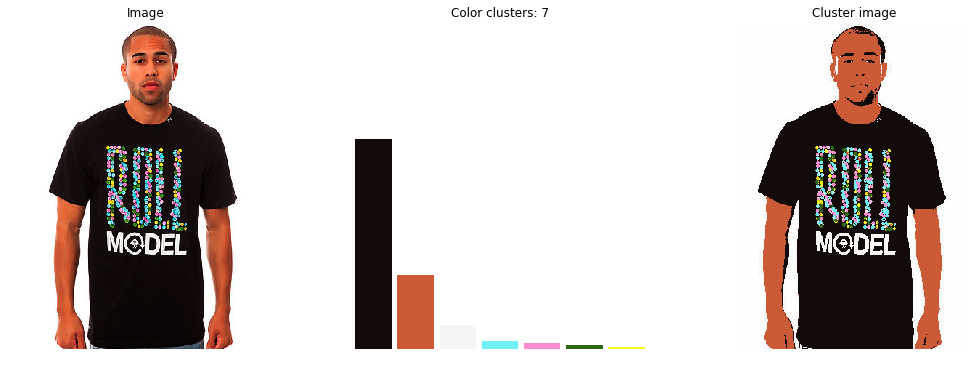

1 : black ≈ 1.5683081270856538 
LAB: [3.59760192 2.26352409 1.08493112] ∈ [1.09837673 2.36610118 1.68859566]
RGB: [18.22541428 11.21399698 10.57533536]
2 : orange ≈ 2.180261280582533 
LAB: [52.3981307  42.33255575 41.95291898] ∈ [51.51403455 43.13338307 38.44267318]
RGB: [203.33795403  90.99772926  54.4629975 ]
3 : gray ≈ 0.44432731393830294 
LAB: [96.5822885  -0.22565734  0.92247942] ∈ [96.51244707 -0.17641916  0.47159351]
RGB: [245.49730431 245.19714275 243.35730167]
4 : blue ≈ 3.483259176092709 
LAB: [ 88.21813018 -35.06609275 -12.51192658] ∈ [ 90.51160054 -28.01702472 -12.68650261]
RGB: [109.29663719 240.69390705 243.89560428]
5 : purple ≈ 6.778429482962619 
LAB: [ 72.21050621  50.28194898 -16.48414379] ∈ [ 69.48806735  72.80908352 -13.89433457]
RGB: [251.02659524 140.43052015 208.38115849]
6 : green ≈ 1.703054935580558 
LAB: [ 39.49392094 -35.19926784  39.56024902] ∈ [ 38.88967411 -37.43899922  44.37208376]
RGB: [ 47.41287325 105.89586747  19.36349671]
7 : yellow ≈ 0.5483933473109

In [2]:
%%time
filename = './pics/lyst.png'

result = get_color_names(filename)

Bandwidth: 8.699061498352622


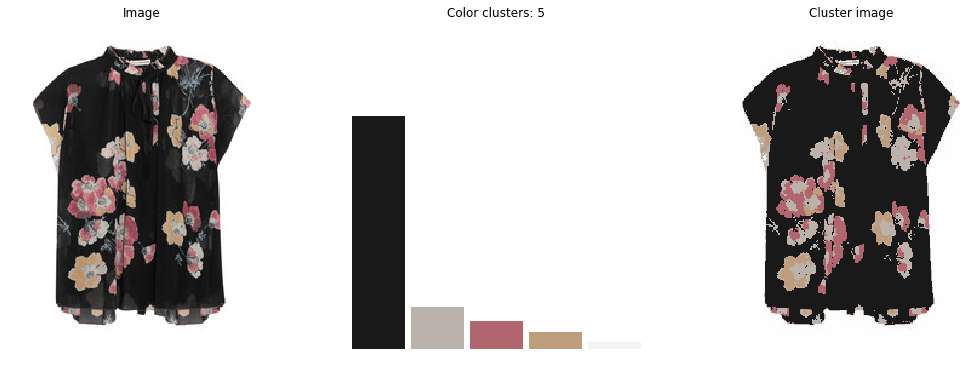

1 : black ≈ 4.972899904908874 
LAB: [ 9.02661672e+00 -6.52345347e-03  5.18834007e-02] ∈ [1.44682396 0.08905075 2.16864237]
RGB: [25.55509225 25.53184902 25.46468808]
2 : gray ≈ 2.956152613357339 
LAB: [73.10690818  1.77745461  4.23255978] ∈ [73.0299152  -0.20166621  5.08482051]
RGB: [186.25581832 178.10676716 171.84032857]
3 : red ≈ 3.7890925151606196 
LAB: [51.58282581 31.62200947  7.17965399] ∈ [53.30751541 33.94538257 12.75696872]
RGB: [176.53130993 101.0229423  111.99693562]
4 : brown ≈ 2.1964949993774847 
LAB: [67.14337137  7.43101066 22.01296962] ∈ [67.1397665  5.167363  22.1134475]
RGB: [190.65752461 157.62287588 124.31295045]
5 : gray ≈ 0.9499850327896702 
LAB: [96.00950608  0.40814147  0.72554187] ∈ [96.51244707 -0.17641916  0.47159351]
RGB: [244.96938427 243.17505538 242.11288894]
black 71.45 %
gray 14.74 %
red 8.62 %
brown 5.18 %
Wall time: 1.48 s


In [3]:
%%time
filename = './pics/nap_852988.jpg'

result = get_color_names(filename)

Bandwidth: 20.754605496601688


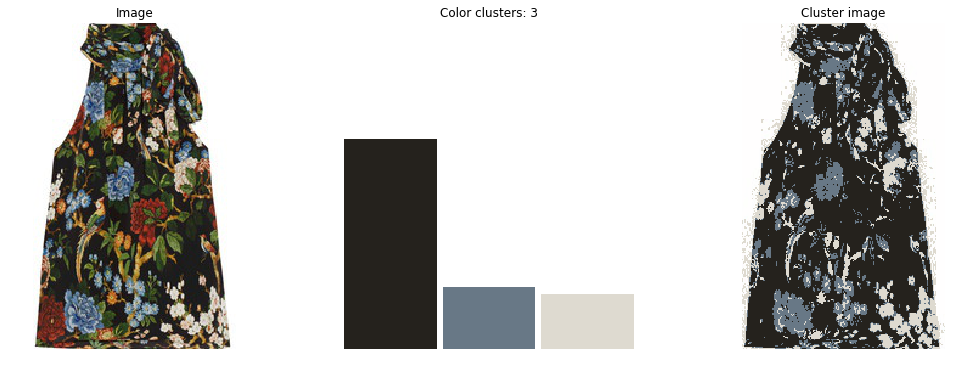

1 : brown ≈ 6.145034748440882 
LAB: [13.81463164  0.31478074  4.03627572] ∈ [5.37562894 0.47142502 8.0601057 ]
RGB: [37.98560319 34.86505294 29.6471654 ]
2 : blue ≈ 3.6815395591612057 
LAB: [49.99637171 -2.66646899 -9.50278129] ∈ [51.85587653 -5.34243484 -8.59325255]
RGB: [104.9643042  120.98398935 134.81903916]
3 : gray ≈ 2.9726448367890854 
LAB: [87.2444793  -0.21643724  5.19926375] ∈ [89.15178269 -0.37161041  2.06497986]
RGB: [222.53822514 218.30091812 208.76667669]
brown 64.45 %
blue 18.83 %
gray 16.72 %
Wall time: 1.28 s


In [4]:
%%time
filename = './pics/Blouses3.jpg'

result = get_color_names(filename)

Bandwidth: 5


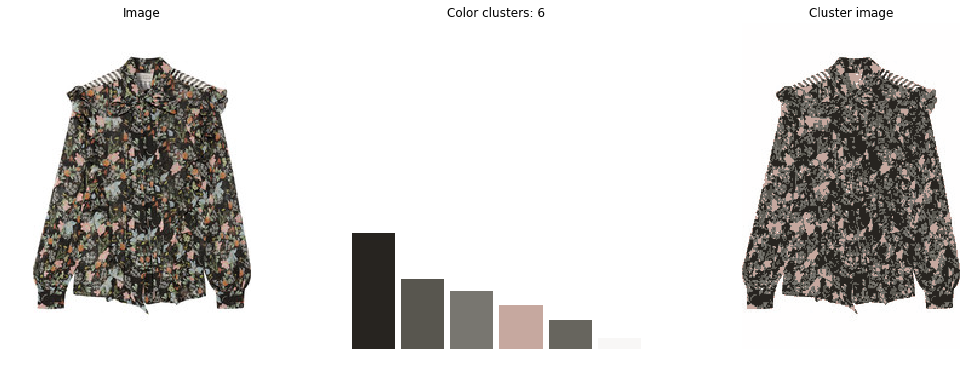

1 : gray ≈ 5.615422112951359 
LAB: [14.80716373  0.24273097  3.30058086] ∈ [ 2.17042709e+01 -1.49318491e-04 -2.78278941e-03]
RGB: [39.58415972 36.98651078 32.68272432]
2 : gray ≈ 2.2833365323823664 
LAB: [36.87240566 -0.72273422  4.63843771] ∈ [35.48697237 -1.45534199  2.77642215]
RGB: [88.77699546 86.81848501 79.32468152]
3 : brown ≈ 2.8496144132545136 
LAB: [49.9441533  -0.63654007  3.89038823] ∈ [49.35049783 -0.32021085  7.30332775]
RGB: [120.59214428 118.86545746 112.21460399]
4 : brown ≈ 3.6729030788273773 
LAB: [71.44887198  9.5944128   8.68732867] ∈ [74.79771557 11.65925573 12.34183135]
RGB: [198.78180487 168.53866727 159.64390765]
5 : gray ≈ 1.9237437303086475 
LAB: [42.91216845 -0.77429912  4.44621932] ∈ [44.1295763  -1.79732333  3.79524075]
RGB: [103.2204096  101.44398508  94.02281614]
6 : gray ≈ 0.7219879655481194 
LAB: [97.52027189 -0.20092912  0.89598896] ∈ [96.51244707 -0.17641916  0.47159351]
RGB: [248.22687599 247.88578008 246.10732699]
gray 68.74 %
brown 31.26 %
Wall t

In [5]:
%%time
filename = './pics/nap_896918.jpg'

result = get_color_names(filename, bandwidth=5)

Bandwidth: 5.899997282713706


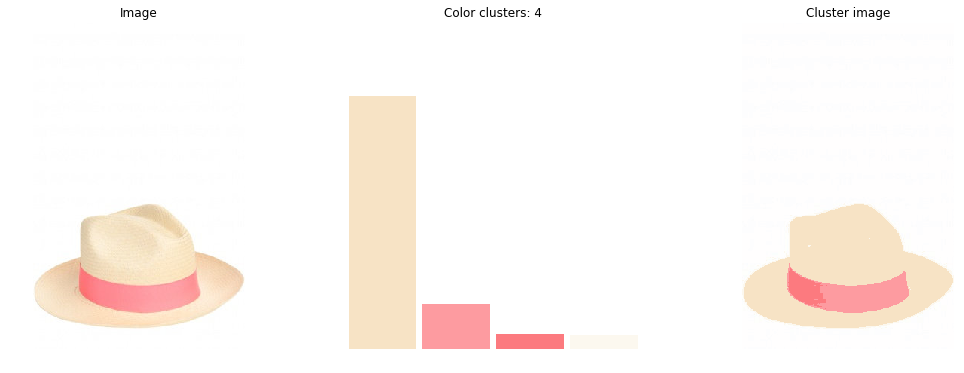

1 : brown ≈ 3.1593695046998347 
LAB: [91.16612442  2.34704423 17.09134438] ∈ [86.32012782  2.83845942 18.10685993]
RGB: [247.434828   227.02524845 197.24213585]
2 : red ≈ 4.66743976787594 
LAB: [74.30310709 37.07531029 13.01909987] ∈ [71.77007663 30.07215605  6.63636761]
RGB: [253.51668451 155.57272022 160.60491157]
3 : brown ≈ 4.75513403220521 
LAB: [66.79749018 50.25006361 21.05517084] ∈ [69.80657452 58.01462703 30.35639739]
RGB: [252.92428638 122.11512075 127.41585373]
4 : gray ≈ 3.367255258426368 
LAB: [97.76684556 -0.29825084  4.93246303] ∈ [96.14383617 -2.2233972   3.00690986]
RGB: [252.2595775  248.36022679 239.0358799 ]
brown 82.08 %
red 13.74 %
gray 4.18 %
Wall time: 1.25 s


In [6]:
%%time
filename = './pics/tsm_1582196.jpg'

result = get_color_names(filename)

Bandwidth: 6.42602040641328


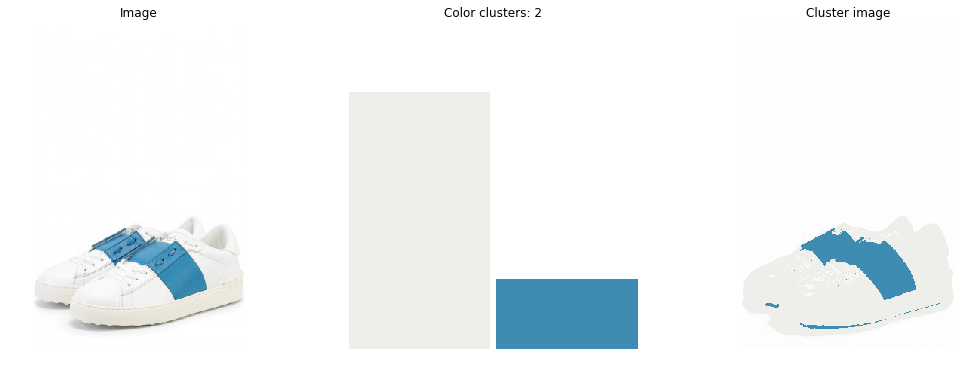

1 : gray ≈ 1.9468293943151824 
LAB: [94.09917161 -0.54280709  1.85723512] ∈ [ 9.40978195e+01 -4.36015336e-04 -8.12584461e-03]
RGB: [238.55202018 238.1961069  234.44438015]
2 : blue ≈ 2.8489648238225302 
LAB: [ 55.42993971 -11.59426474 -27.34633753] ∈ [ 54.73988703 -14.62795225 -33.32768932]
RGB: [ 63.64082204 140.81654397 179.55937007]
gray 78.72 %
blue 21.28 %
Wall time: 972 ms


In [7]:
%%time
filename = './pics/tsm_1812421.jpg'

result = get_color_names(filename)

Bandwidth: 21.613326627901206


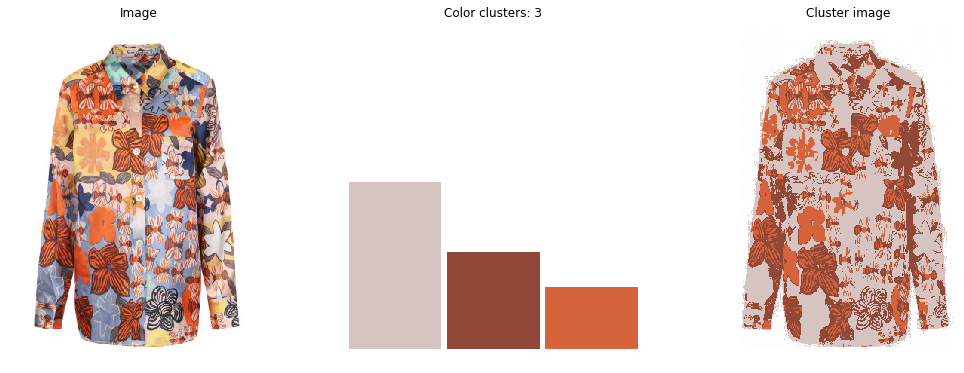

1 : gray ≈ 5.064729335420657 
LAB: [80.83028233  5.57926617  3.86541117] ∈ [77.11253837  2.0934676   1.87471959]
RGB: [214.48566634 196.958641   193.68196574]
2 : brown ≈ 1.588216536734658 
LAB: [39.68498683 28.8877412  24.49282649] ∈ [39.02442892 25.68650784 22.89832611]
RGB: [145.2623751   72.81234089  55.06582004]
3 : orange ≈ 2.4842532455421398 
LAB: [55.68747457 42.3749413  43.39723437] ∈ [56.18803879 46.88592634 42.41825788]
RGB: [213.81056907  99.45313626  59.48478123]
gray 51.15 %
brown 29.75 %
orange 19.09 %
Wall time: 3.06 s


In [8]:
%%time
filename = './pics/tsm_2268951.jpg'

result = get_color_names(filename)

In [9]:
"""
OLD CODE HERE

def closest_colour(requested_colour, d = webcolors.css3_hex_to_names):

    #for pure web colors change: d = webcolors.css3_hex_to_names
    #for tsum css colors change: d = pd.DataFrame.from_csv('css3_colors').tsum_color.to_dict()

    min_colours = {}
    for key, name in d.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return closest_name

def get_color_names(filename, bandwidth=None, quantile=.023, n_samples=1000, white_thrsh=250, bin_seeding=True, min_bin_freq=150):
    d = {}
    colors, counts = get_colors(filename, bandwidth, quantile, n_samples, white_thrsh, bin_seeding, min_bin_freq)
    for rgb, cnt in zip(colors, counts):
        r, g, b = rgb
        lab = sRGBColor(r, g, b, True)
        lab = convert_color(lab, LabColor, target_illuminant='e')
        lab = np.array([lab.lab_l, lab.lab_a, lab.lab_b])
        delta = delta_e_cie2000(lab, lab_matrix)
        color = lab_colors[np.argmin(delta)]
        print (rgb, lab, cnt, color)
        if color in d:
            d[color] += cnt[0]/counts.sum()
        else:
            d[color] = float(cnt[0])/counts.sum()
    return d

def get_color_names(filename, bandwidth=None, quantile=.023, n_samples=1000, white_thrsh=250, bin_seeding=True, min_bin_freq=75):
    d = {}
    colors, counts = get_colors(filename, bandwidth, quantile, n_samples, white_thrsh, bin_seeding, min_bin_freq)
    for rgb, cnt in zip(colors, counts):
        color = get_colour_name(rgb)        
        if color in d:
            d[color] += cnt[0]/counts.sum()
        else:
            d[color] = float(cnt[0])/counts.sum()
    
    for key, val in d.items():
        print ('%s %.2f %%' % (key, 100*val))
    return d
"""

"\nOLD CODE HERE\n\ndef closest_colour(requested_colour, d = webcolors.css3_hex_to_names):\n\n    #for pure web colors change: d = webcolors.css3_hex_to_names\n    #for tsum css colors change: d = pd.DataFrame.from_csv('css3_colors').tsum_color.to_dict()\n\n    min_colours = {}\n    for key, name in d.items():\n        r_c, g_c, b_c = webcolors.hex_to_rgb(key)\n        rd = (r_c - requested_colour[0]) ** 2\n        gd = (g_c - requested_colour[1]) ** 2\n        bd = (b_c - requested_colour[2]) ** 2\n        min_colours[(rd + gd + bd)] = name\n    return min_colours[min(min_colours.keys())]\n\ndef get_colour_name(requested_colour):\n    try:\n        closest_name = webcolors.rgb_to_name(requested_colour)\n    except ValueError:\n        closest_name = closest_colour(requested_colour)\n    return closest_name\n\ndef get_color_names(filename, bandwidth=None, quantile=.023, n_samples=1000, white_thrsh=250, bin_seeding=True, min_bin_freq=150):\n    d = {}\n    colors, counts = get_colors(fi